In [325]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import collections.abc as container_abcs
from itertools import repeat

In [326]:
Ng = 64 #number of points
LL = 1.0#2 * np.pi #interval of data
k = np.asarray(list(np.arange(0, Ng // 2,1/Ng)) + [0] + list(np.arange(-Ng // 2 + 1,0,1/Ng)))
[Kx,Ky]=np.array( np.meshgrid ( k , k ,indexing ='ij') , dtype = int )
f = lambda x: np.sin((2*np.pi/LL)*x)
df_analytical = lambda x: (2*np.pi/LL)*np.cos((2*np.pi/LL)*x)
f(Kx).shape

(4033, 4033)

In [327]:
np.max(df_analytical(Kx)),np.min(df_analytical(Kx)),np.max(Kx),np.min(Kx)

(6.283185307179586, 6.283185307179586, 31, -31)

https://stackoverflow.com/questions/29189885/finding-the-derivative-of-a-2d-function-using-fft-properties

https://math.stackexchange.com/questions/1473277/taking-partial-derivative-via-fourier-transform-using-matlab

In [328]:
def ntuple(n):
    def parse(x):
        if isinstance(x, container_abcs.Iterable) and not isinstance(x, str):
            return x
        return tuple(repeat(x, n))

    return parse

def make_kernel(mode, d):
    if mode == 'sobel':
        hxyz = torch.tensor([1, 2, 1], dtype=torch.float32)
    elif mode == 'scharr':
        hxyz = torch.tensor([3, 10, 3], dtype=torch.float32)
    else:
        raise ValueError('Not valid mode')
    hpxyz = torch.tensor([-1, 0, 1], dtype=torch.float32)
    if d == 1:
        kernel = torch.zeros((1, 3), dtype=torch.float32)
        for i in range(3):
            kernel[0][i] = hpxyz[i]
        kernel = kernel / kernel.abs().sum(dim=[-1]).view(-1, 1)
    elif d == 2:
        kernel = torch.zeros((2, 3, 3), dtype=torch.float32)
        for i in range(3):
            for j in range(3):
                kernel[0][i][j] = hpxyz[i] * hxyz[j]
                kernel[1][i][j] = hxyz[i] * hpxyz[j]
        kernel = kernel / kernel.abs().sum(dim=[-2, -1]).view(-1, 1, 1)
    elif d == 3:
        kernel = torch.zeros((3, 3, 3, 3), dtype=torch.float32)
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    kernel[0][i][j][k] = hpxyz[i] * hxyz[j] * hxyz[k]
                    kernel[1][i][j][k] = hxyz[i] * hpxyz[j] * hxyz[k]
                    kernel[2][i][j][k] = hxyz[i] * hxyz[j] * hpxyz[k]
        kernel = kernel / kernel.abs().sum(dim=[-3, -2, -1]).view(-1, 1, 1, 1)
    return kernel

In [329]:
# 1 D
N = 64 #number of points
L = 2 * np.pi #interval of data
x = np.arange(0.0, L, L/float(N)) #this does not include the endpoint
dx = L/float(N)
k=np.fft.fftfreq(N,1/N)
#k= np.asarray(list(range(0, N // 2)) + [0] + list(range(-N // 2 + 1,0)))
k = (2 * np.pi / L)*k

X=x
data_spacedomain = np.sin(X*2*np.pi/L)
dx_analytical=np.cos(X*2*np.pi/L)*2*np.pi/L

#% Compute 2D FFT
data_wavenumberdomain = np.fft.fftn(data_spacedomain)

#% Compute grid of wavenumbers
KX=k#KX, KY = np.meshgrid (k, k , indexing ='ij');

#% Compute 2D derivative
data_wavenumberdomain_differentiated_x =  1j*KX*data_wavenumberdomain
#% Convert back to space domain
data_spacedomain_differentiated_x = np.real(np.fft.ifftn(data_wavenumberdomain_differentiated_x))

C = 1
D = 1
mode = 'sobel'
padding_mode = 'none'
data = torch.tensor(data_spacedomain, dtype=torch.float32).view(1,1,N)
kernel = make_kernel(mode, D)
kernel = kernel.unsqueeze(1).repeat(C, 1, 1)
if padding_mode == 'replicate':
    padding = tuple(x for x in reversed(ntuple(D)(kernel.size(-1) // 2)) for _ in range(2))
    finite_derivative = F.conv1d(F.pad(data, padding, 'replicate'), kernel, padding=0, groups=C) / dx
elif padding_mode == 'reflect':
    padding = tuple(x for x in reversed(ntuple(D)(kernel.size(-1) // 2)) for _ in range(2))
    finite_derivative = F.conv1d(F.pad(data, padding, 'reflect'), kernel, padding=0, groups=C) / dx
elif padding_mode == 'zeros':
    finite_derivative = F.conv1d(data, kernel, padding=1, groups=C) / dx
elif padding_mode == 'none':
    finite_derivative = F.conv1d(data, kernel, padding=0, groups=C) / dx
else:
    raise ValueError('Not valid padding mode')
finite_derivative_x = finite_derivative[0,0].numpy()

L1_FFT_x = np.abs(data_spacedomain_differentiated_x-dx_analytical)

if padding_mode == 'none':
    L1_Finite_x = np.abs(finite_derivative_x-dx_analytical[1:-1])
else:
    L1_Finite_x = np.abs(finite_derivative_x-dx_analytical)

print('Mean FFT derivative error: (X: {})'.format(np.mean(L1_FFT_x)))
print('Mean Finite derivative error: (X: {})'.format(np.mean(L1_Finite_x)))
print('Max FFT derivative error: (X: {})'.format(np.max(L1_FFT_x)))
print('Max Finite derivative error: (X: {})'.format(np.max(L1_Finite_x)))

Mean FFT derivative error: (X: 1.987747087057671e-15)
Mean Finite derivative error: (X: 0.001002633409686339)
Max FFT derivative error: (X: 1.2989609388114332e-14)
Max Finite derivative error: (X: 0.0016056299209594727)


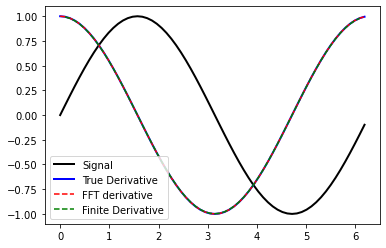

In [330]:
plt.plot(x,data_spacedomain,color='k',LineWidth=2,label='Signal')
plt.plot(x,dx_analytical,color='b',LineWidth=2,label='True Derivative')
plt.plot(x,data_spacedomain_differentiated_x,'--',color='r',LineWidth=1.5,label='FFT derivative')
if padding_mode == 'none':
    plt.plot(x[1:-1],finite_derivative_x,'--',color='g',LineWidth=1.5,label='Finite Derivative')
else:
    plt.plot(x,finite_derivative_x,'--',color='g',LineWidth=1.5,label='Finite Derivative')
plt.legend()
plt.show()

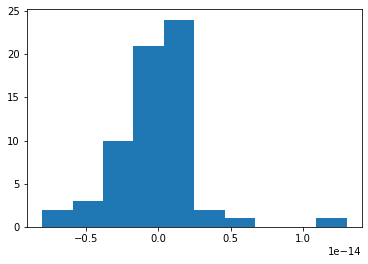

In [331]:
plt.hist((data_spacedomain_differentiated_x-dx_analytical).ravel())
pass

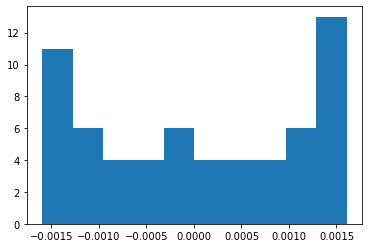

In [332]:
if padding_mode == 'none':
    plt.figure()
    plt.hist((finite_derivative_x-dx_analytical[1:-1]).ravel())
else:
    plt.figure()
    plt.hist((finite_derivative_x-dx_analytical).ravel())    
pass

In [333]:
# n D (2D)
N = 128 #number of points
L = 2 * np.pi #interval of data
indexing = 'ij'
x = np.arange(0.0, L, L/float(N)) #this does not include the endpoint
dx = L/float(N)
k=np.fft.fftfreq(N,1/N)
k = (2 * np.pi / L)*k

X,Y = np.meshgrid(x, x, indexing=indexing)
data_spacedomain = np.sin(X*2*np.pi/L)
dx_analytical=np.cos(X*2*np.pi/L)*2*np.pi/L
dy_analytical=np.zeros(dx_analytical.shape)
#% Compute 2D FFT
data_wavenumberdomain = np.fft.fftn(data_spacedomain)
#% Compute grid of wavenumbers
KX, KY = np.meshgrid (k, k, indexing=indexing)

#% Compute 2D derivative
data_wavenumberdomain_differentiated_x =  1j*KX*data_wavenumberdomain
data_wavenumberdomain_differentiated_y =  1j*KY*data_wavenumberdomain
#% Convert back to space domain
data_spacedomain_differentiated_x = np.real(np.fft.ifftn(data_wavenumberdomain_differentiated_x))
data_spacedomain_differentiated_y = np.real(np.fft.ifftn(data_wavenumberdomain_differentiated_y))

C = 1
D = 2
mode = 'sobel'
padding_mode = 'none'
data = torch.tensor(data_spacedomain, dtype=torch.float32).view(1,1,N,N)
kernel = make_kernel(mode, D)
kernel = kernel.unsqueeze(1).repeat(C, 1, 1, 1)
if padding_mode == 'replicate':
    padding = tuple(x for x in reversed(ntuple(D)(kernel.size(-1) // 2)) for _ in range(2))
    finite_derivative = F.conv2d(F.pad(data, padding, 'replicate'), kernel, padding=0, groups=C) / dx
elif padding_mode == 'reflect':
    padding = tuple(x for x in reversed(ntuple(D)(kernel.size(-1) // 2)) for _ in range(2))
    finite_derivative = F.conv2d(F.pad(data, padding, 'reflect'), kernel, padding=0, groups=C) / dx
elif padding_mode == 'zeros':
    finite_derivative = F.conv2d(data, kernel, padding=1, groups=C) / dx
elif padding_mode == 'none':
    finite_derivative = F.conv2d(data, kernel, padding=0, groups=C) / dx
else:
    raise ValueError('Not valid padding mode')
finite_derivative_x = finite_derivative[0,0].numpy()
finite_derivative_y = finite_derivative[0,1].numpy()

L1_FFT_x = np.abs(data_spacedomain_differentiated_x-dx_analytical)
L1_FFT_y = np.abs(data_spacedomain_differentiated_y-dy_analytical)

if padding_mode == 'none':
    L1_Finite_x = np.abs(finite_derivative_x-dx_analytical[1:-1,1:-1])
    L1_Finite_y = np.abs(finite_derivative_y-dy_analytical[1:-1,1:-1])
else:
    L1_Finite_x = np.abs(finite_derivative_x-dx_analytical)
    L1_Finite_y = np.abs(finite_derivative_y-dy_analytical)

print('Mean FFT derivative error: (X: {}, Y:{})'.format(np.mean(L1_FFT_x), np.mean(L1_FFT_y)))
print('Mean Finite derivative error: (X: {}, Y:{})'.format(np.mean(L1_Finite_x), np.mean(L1_Finite_y)))
print('Max FFT derivative error: (X: {}, Y:{})'.format(np.max(L1_FFT_x), np.max(L1_FFT_y)))
print('Max Finite derivative error: (X: {}, Y:{})'.format(np.max(L1_Finite_x), np.max(L1_Finite_y)))

Mean FFT derivative error: (X: 5.072848839968119e-15, Y:0.0)
Mean Finite derivative error: (X: 0.00025326654896901086, Y:0.0)
Max FFT derivative error: (X: 2.4424906541753444e-14, Y:0.0)
Max Finite derivative error: (X: 0.00040155649185180664, Y:0.0)


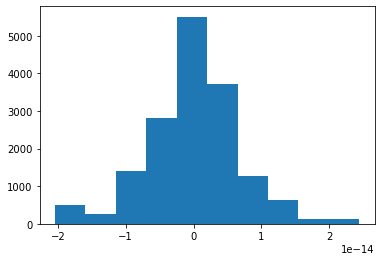

In [334]:
plt.hist((data_spacedomain_differentiated_x-dx_analytical).ravel())
pass

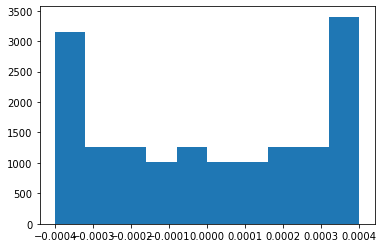

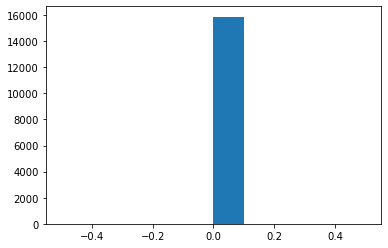

In [335]:
if padding_mode == 'none':
    plt.figure()
    plt.hist((finite_derivative_x-dx_analytical[1:-1,1:-1]).ravel())
    plt.figure()
    plt.hist((finite_derivative_y-dy_analytical[1:-1,1:-1]).ravel())    
else:
    plt.figure()
    plt.hist((finite_derivative_x-dx_analytical).ravel())
    plt.figure()
    plt.hist((finite_derivative_y-dy_analytical).ravel())
pass

In [336]:
# n D (3D)
N = 128 #number of points
L = 2 * np.pi #interval of data
indexing = 'ij'
x = np.arange(0.0, L, L/float(N)) #this does not include the endpoint
dx = L/float(N)
k=np.fft.fftfreq(N,1/N)
k = (2 * np.pi / L)*k

X,Y,Z = np.meshgrid (x, x, x, indexing=indexing)
data_spacedomain = np.sin(X*2*np.pi/L) + np.sin(Y*2*np.pi/L)
dx_analytical=np.cos(X*2*np.pi/L)*2*np.pi/L
dy_analytical=np.cos(Y*2*np.pi/L)*2*np.pi/L
dz_analytical=np.zeros(dx_analytical.shape)
#% Compute 2D FFT
data_wavenumberdomain = np.fft.fftn(data_spacedomain)
#% Compute grid of wavenumbers
KX, KY, KZ = np.meshgrid(k, k, k, indexing=indexing)

#% Compute 2D derivative
data_wavenumberdomain_differentiated_x = 1j*KX*data_wavenumberdomain
data_wavenumberdomain_differentiated_y = 1j*KY*data_wavenumberdomain
data_wavenumberdomain_differentiated_z = 1j*KZ*data_wavenumberdomain
#% Convert back to space domain
data_spacedomain_differentiated_x = np.real(np.fft.ifftn(data_wavenumberdomain_differentiated_x))
data_spacedomain_differentiated_y = np.real(np.fft.ifftn(data_wavenumberdomain_differentiated_y))
data_spacedomain_differentiated_z = np.real(np.fft.ifftn(data_wavenumberdomain_differentiated_z))

C = 1
D = 3
mode = 'sobel'
padding_mode = 'none'
data = torch.tensor(data_spacedomain, dtype=torch.float32).view(1,1,N,N,N)
kernel = make_kernel(mode, D)
kernel = kernel.unsqueeze(1).repeat(C, 1, 1, 1, 1)
if padding_mode == 'replicate':
    padding = tuple(x for x in reversed(ntuple(D)(kernel.size(-1) // 2)) for _ in range(2))
    finite_derivative = F.conv3d(F.pad(data, padding, 'replicate'), kernel, padding=0, groups=C) / dx
elif padding_mode == 'zeros':
    finite_derivative = F.conv3d(data, kernel, padding=1, groups=C) / dx
elif padding_mode == 'none':
    finite_derivative = F.conv3d(data, kernel, padding=0, groups=C) / dx
else:
    raise ValueError('Not valid padding mode')
finite_derivative_x = finite_derivative[0,0].numpy()
finite_derivative_y = finite_derivative[0,1].numpy()
finite_derivative_z = finite_derivative[0,2].numpy()

L1_FFT_x = np.abs(data_spacedomain_differentiated_x-dx_analytical)
L1_FFT_y = np.abs(data_spacedomain_differentiated_y-dy_analytical)
L1_FFT_z = np.abs(data_spacedomain_differentiated_z-dz_analytical)

if padding_mode == 'none':
    L1_Finite_x = np.abs(finite_derivative_x-dx_analytical[1:-1,1:-1,1:-1])
    L1_Finite_y = np.abs(finite_derivative_y-dy_analytical[1:-1,1:-1,1:-1])
    L1_Finite_z = np.abs(finite_derivative_z-dz_analytical[1:-1,1:-1,1:-1])
else:
    L1_Finite_x = np.abs(finite_derivative_x-dx_analytical)
    L1_Finite_y = np.abs(finite_derivative_y-dy_analytical)
    L1_Finite_z = np.abs(finite_derivative_z-dz_analytical)

print('Mean FFT derivative error: (X: {}, Y:{}, Z:{})'.format(np.mean(L1_FFT_x), np.mean(L1_FFT_y), np.mean(L1_FFT_z)))
print('Mean Finite derivative error: (X: {}, Y:{}, Z:{})'.format(np.mean(L1_Finite_x), np.mean(L1_Finite_y), np.mean(L1_Finite_z)))
print('Max FFT derivative error: (X: {}, Y:{}, Z:{})'.format(np.max(L1_FFT_x), np.max(L1_FFT_y), np.max(L1_FFT_z)))
print('Max Finite derivative error: (X: {}, Y:{}, Z:{})'.format(np.max(L1_Finite_x), np.max(L1_Finite_y), np.max(L1_Finite_z)))

Mean FFT derivative error: (X: 5.839559771462585e-15, Y:5.553467124713489e-15, Z:0.0)
Mean Finite derivative error: (X: 0.00025328805611142486, Y:0.0002532861655453965, Z:0.0)
Max FFT derivative error: (X: 2.786659791809143e-14, Y:2.842170943040401e-14, Z:0.0)
Max Finite derivative error: (X: 0.0004024505615234375, Y:0.00040215253829956055, Z:0.0)


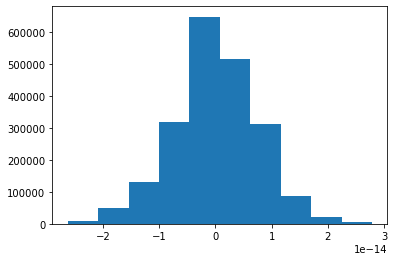

In [337]:
plt.hist((data_spacedomain_differentiated_x-dx_analytical).ravel())
pass

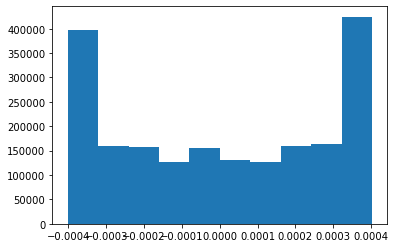

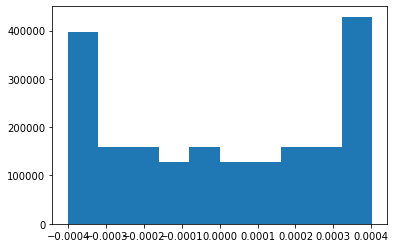

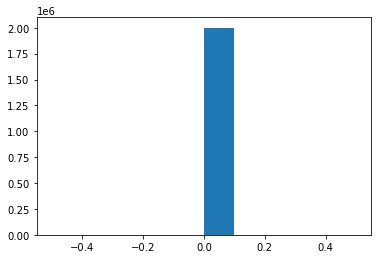

In [338]:
if padding_mode == 'none':
    plt.figure()
    plt.hist((finite_derivative_x-dx_analytical[1:-1,1:-1,1:-1]).ravel())
    plt.figure()
    plt.hist((finite_derivative_y-dy_analytical[1:-1,1:-1,1:-1]).ravel())
    plt.figure()
    plt.hist((finite_derivative_z-dz_analytical[1:-1,1:-1,1:-1]).ravel())
else:
    plt.figure()
    plt.hist((finite_derivative_x-dx_analytical).ravel())
    plt.figure()
    plt.hist((finite_derivative_y-dy_analytical).ravel())
    plt.figure()
    plt.hist((finite_derivative_z-dz_analytical).ravel())
pass